In [1]:
# GPU info
!nvidia-smi

Thu Jan  4 18:00:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
import os

import tensorflow as tf
import keras.backend as K

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import pickle

In [4]:
import re
import string

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv("/content/drive/MyDrive/test/Siamese_for_Article/Data/quora_duplicate_questions.csv")
#data.fillna("none value", inplace=True) # replace nan value to none
# drop the rows with null value
data.dropna(axis=0, inplace=True)
N=len(data)
print('Number of question pairs: ', N)
data.head()

Number of question pairs:  345033


,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
4,4,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1


In [7]:
# model selection
from sklearn.model_selection import train_test_split
data_train , data_test = train_test_split(data, train_size=0.75, random_state=0)
# validation_data, _ = train_test_split(data_train, train_size=0.1, random_state=0)
len(data_train), len(data_test)

(258774, 86259)

In [8]:
train_Q1 = np.array(data_train['question1'])
train_Q2 = np.array(data_train['question2'])
t_labels = np.array(data_train['is_duplicate'])
# make it one-hot encoding
train_labels = tf.keras.utils.to_categorical(t_labels, num_classes=2)

test_Q1 = np.array(data_test['question1'])
test_Q2 = np.array(data_test['question2'])
te_labels  = np.array(data_test['is_duplicate'])
# make it one-hot encoding
test_labels = tf.keras.utils.to_categorical(te_labels, num_classes=2)

In [9]:
#create arrays

Q1_train_tensor = np.empty_like(train_Q1)
Q2_train_tensor = np.empty_like(train_Q2)

Q1_test_tensor = np.empty_like(test_Q1)
Q2_test_tensor = np.empty_like(test_Q2)

Q1_train_tensor.shape, Q1_test_tensor.shape

((258774,), (86259,))

In [10]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,?!.]+", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"'s", " ", text)
    text = re.sub(r"'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"'re", " are ", text)
    text = re.sub(r"'d", " would ", text)
    text = re.sub(r"'ll", " will ", text)
    text = re.sub(r"[,]+", " ", text)
    text = re.sub(r"\.[^ ]*", " .", text)
    text = re.sub(r"\?[^ ]*", " ?", text)
    text = re.sub(r"\![^ ]*", " !", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

In [11]:
# # process train and test questions

Q1_train_words = {}
Q2_train_words = {}

Q1_test_words = {}
Q2_test_words = {}

for idx in range(len(train_Q1)):
    Q1_train_words[idx] = text_to_word_list(train_Q1[idx])
    Q2_train_words[idx] = text_to_word_list(train_Q2[idx])

for idx in range(len(test_Q1)):
    Q1_test_words[idx] = text_to_word_list(test_Q1[idx])
    Q2_test_words[idx] = text_to_word_list(test_Q2[idx])

In [12]:
# make vocabulary
vocab = {}
word_count = 0
for idx in range(len(train_Q1)):

    q = Q1_train_words[idx] + Q2_train_words[idx]
    for word in q:
        if word not in vocab:
            word_count += 1
            vocab[word] = word_count
print('The length of the vocabulary is: ', len(vocab))

The length of the vocabulary is:  65119


In [13]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2024-01-04 18:01:52--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2024-01-04 18:01:52--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2024-01-04 18:01:53--  https://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]


In [14]:
!unzip '/content/glove.42B.300d.zip'

Archive:  /content/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [15]:
path_to_glove_file = '/content/glove.42B.300d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 1917494 word vectors.


In [16]:
num_tokens = len(vocab) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 58031 words (7088 misses)


In [17]:
# Converting questions to array of integers
for i in range(len(train_Q1)):
    Q1_train_tensor[i] = [vocab.get(word, 0) for word in Q1_train_words[i]]
    Q2_train_tensor[i] = [vocab.get(word, 0) for word in Q2_train_words[i]]


for i in range(len(test_Q1)):
    Q1_test_tensor[i] = [vocab.get(word, 0) for word in Q1_test_words[i]]
    Q2_test_tensor[i] = [vocab.get(word, 0) for word in Q2_test_words[i]]

In [18]:
print('first question in the train set:\n')
print(train_Q1[0], '\n', )

print('encoded version:')
print(Q1_train_tensor[0],'\n')

print('first question in the test set:\n')
print(test_Q1[0], '\n')
print('encoded version:')
print(Q1_test_tensor[0])

first question in the train set:

Who is the husband of sunny leone? 

encoded version:
[1, 2, 3, 4, 5, 6, 7, 8] 

first question in the test set:

What was the best day of your life? 

encoded version:
[9, 68, 3, 232, 863, 5, 76, 13, 8]


In [19]:
# For demonstration
pad_sequences(Q1_train_tensor, maxlen=16, padding='post')

array([[    1,     2,     3, ...,     0,     0,     0],
       [    9,     2,     3, ...,     0,     0,     0],
       [    9,    14,    15, ...,     0,     0,     0],
       ...,
       [    9,    14,     3, ...,     0,     0,     0],
       [    9,     2,     3, ...,     0,     0,     0],
       [   50, 14721,   115, ...,     0,     0,     0]], dtype=int32)

In [20]:
class data_generator(tf.keras.utils.Sequence):
    def __init__(self, Q1, Q2, labels, batch_size, max_len, shuffle=True):
        self.Q1 = Q1
        self.Q2 = Q2
        self.labels = labels
        self.batch_size = batch_size
        self.max_len = max_len
        self.shuffle = shuffle

        self.indexes = np.arange(len(self.Q1))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.Q1) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        input1 = self.Q1[indexes]
        input2 = self.Q2[indexes]
        targets = self.labels[indexes]

        pad_input1 = pad_sequences(input1, maxlen=self.max_len, padding='post')
        pad_input2 = pad_sequences(input2, maxlen=self.max_len, padding='post')

        return [pad_input1, pad_input2], targets


    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [21]:
# define model
def create_model(max_len, lstm_units, lr_rate, loss_fn):

    def exponent_neg_manhattan_distance(left, right):
        return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

    # Input tensor placeholders
    left_input = tf.keras.Input(shape=(max_len,), dtype='int32')
    right_input = tf.keras.Input(shape=(max_len,), dtype='int32')

    # Embedding layer
    embedding_dim = 300
    embedding_layer = Embedding(len(vocab)+2, embedding_dim, weights=[embedding_matrix], trainable=True)

    # Add the embedding dimension to input placeholders
    encoded_left = embedding_layer(left_input)
    encoded_right = embedding_layer(right_input)

    # Initialise the LSTM
    shared_lstm = tf.keras.layers.LSTM(lstm_units)
    encoded_l = shared_lstm(encoded_left)
    encoded_r = shared_lstm(encoded_right)

    # Calculates the manhattan distance
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = tf.keras.layers.Lambda(lambda tensors: exponent_neg_manhattan_distance(tensors[0], tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(L1_distance)

    # Build the model
    model = tf.keras.Model(inputs=[left_input, right_input], outputs=[L1_distance])

    # compile model
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate),
        loss = loss_fn,
        metrics = ['accuracy'],
    )

    return model


In [22]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    loss_fn = tf.keras.losses.MeanSquaredError()
    model = create_model(max_len = 64,
                        lstm_units = 64,
                        lr_rate = 0.001,
                        loss_fn = loss_fn
                    )

# print(f"Strategy: {strategy}")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 300)              1953630   ['input_1[0][0]',             
                                                          0          'input_2[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 64)                   93440     ['embedding[0][0]',       

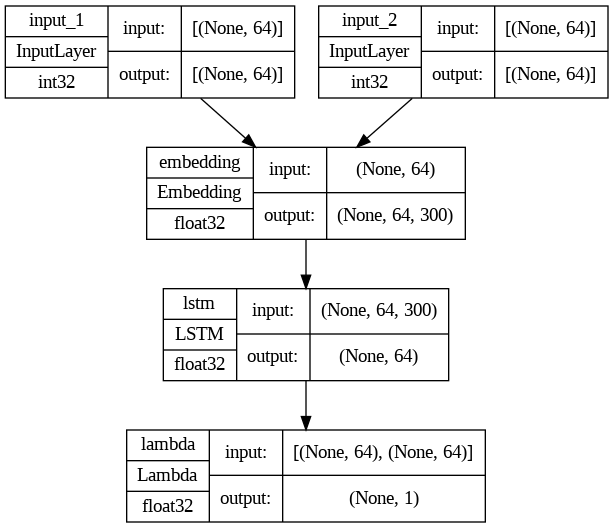

In [23]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True)

In [24]:
batch_size = 256
train_data = data_generator(
    Q1_train_tensor,
    Q2_train_tensor,
    t_labels,
    batch_size,
    64,
    )
valid_data = data_generator(
    Q1_test_tensor,
    Q2_test_tensor,
    te_labels,
    batch_size,
    64,
    shuffle=False,
    )

In [25]:
# change learning rate

tf.keras.backend.set_value(model.optimizer.lr, 0.001)
print(tf.keras.backend.get_value(model.optimizer.lr))

0.001


In [26]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [27]:
epochs = 100
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    callbacks = [callback],
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/100
1010/1010 [==============================] - 68s 61ms/step - loss: 0.2252 - accuracy: 0.6662 - val_loss: 0.1694 - val_accuracy: 0.7525
Epoch 2/100
1010/1010 [==============================] - 29s 29ms/step - loss: 0.1472 - accuracy: 0.7889 - val_loss: 0.1485 - val_accuracy: 0.7886
Epoch 3/100
1010/1010 [==============================] - 29s 28ms/step - loss: 0.1226 - accuracy: 0.8304 - val_loss: 0.1449 - val_accuracy: 0.7925
Epoch 4/100
1010/1010 [==============================] - 24s 24ms/step - loss: 0.1087 - accuracy: 0.8538 - val_loss: 0.1367 - val_accuracy: 0.8086
Epoch 5/100
1010/1010 [==============================] - 25s 25ms/step - loss: 0.0980 - accuracy: 0.8711 - val_loss: 0.1380 - val_accuracy: 0.8087
Epoch 6/100
1010/1010 [==============================] - 25s 25ms/step - loss: 0.0885 - accuracy: 0.8879 - val_loss: 0.1353 - val_accuracy: 0.8085
Epoch 7/100
1010/1010 [==============================] - 23s 23ms/step - loss: 0.0810 - accuracy: 0.9001 - val_loss: 0

In [28]:
preds = model.predict(
    valid_data,
    batch_size=batch_size,
    use_multiprocessing=True
)


336/336 [==============================] - 4s 10ms/step


In [29]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
y_pred = np.where(preds > 0.5, 1, 0)
n = y_pred.shape[0]
y_true = te_labels[:n]
print('accuracy: ', accuracy_score(y_true, y_pred))
print('F1 score: ', f1_score(y_true, y_pred))
print('Recall score: ', recall_score(y_true, y_pred))
print('confusion matrix: \n', confusion_matrix(y_true, y_pred))

accuracy:  0.8277762276785714
F1 score:  0.7697902097902098
Recall score:  0.7310939252612315
confusion matrix: 
 [[46434  5704]
 [ 9110 24768]]


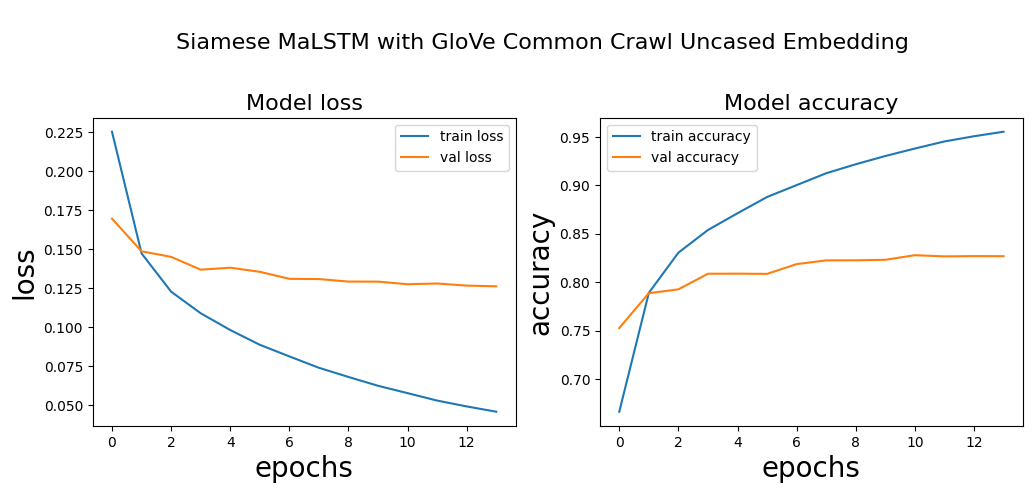

In [30]:
# draw plots
fig, axs = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle('\nSiamese MaLSTM with GloVe Common Crawl Uncased Embedding', x=0.5, y=1.15,fontsize=16)

axs[0].plot(history.history['loss'], label='train loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].set_title('\nModel loss', fontsize=16)
axs[0].set_xlabel('epochs', fontsize=20)
axs[0].set_ylabel('loss', fontsize=20)
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='train accuracy')
axs[1].plot(history.history['val_accuracy'], label='val accuracy')
axs[1].set_title('\nModel accuracy', fontsize=16)
axs[1].set_xlabel('epochs', fontsize=20)
axs[1].set_ylabel('accuracy', fontsize=20)
axs[1].legend()

plt.show()